In [513]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d

In [514]:
N = 10
X = np.zeros((3,N))
X[:,0] = [5,5,0]
X[:,1] = [-5,5,0]
X[:,2] = [-5,-5,0]
X[:,3] = [5,-5,0]
X[:,4:] = np.random.randint(10, size = np.shape(X[:,4:]))
X
A = np.zeros((N,N))
def create_edge(A, i,j):
    """
    Function that creates edges between nodes 
    A: Matrix which indicates if there is an edge between nodes 
    i: first node (can be a list) 
    j: second node (can be a list) 
    
    """
    A[i,j] = 1
    A[j,i] = 1  
edges = np.array([[1,5], [5,6], [4,5], [2,6], [6,7], [3,7], [4,7], [0,4], [7, 8], [8,9]])
create_edge(A, edges[:,0], edges[:,1])
fixed_points = [0,1,2,3]

In [515]:
def E_cable_elast(X, A, k =  3, l_ij = 3):
    energy = 0 
    N = np.shape(A)[0]
    for i in range(N):
        for j in range(i, N):
            if(A[i,j] and np.linalg.norm(X[:,i] - X[:,j], 2) > l_ij):
                energy +=(np.linalg.norm(X[:,i] - X[:,j], 2) - l_ij)**2
    return k/(2*l_ij**2) * energy


def E_ext(X, mg):
    return np.sum(X[2] * mg)


def E(X, A, mg, k = 3, l_ij = 3):
    return E_cable_elast(X,A) + E_ext(X,mg)


def gradient_E_cable_elast(x_i, x_j, k = 3, l_ij = 3):
    norm = np.linalg.norm(x_i - x_j, 2)
    if(norm > l_ij):
        return k/(l_ij**2) * (norm - l_ij) * (x_i - x_j)/norm 
    else:
        return np.zeros_like(x_i -x_j)

def gradient_E_ext(x_i,mg_i):
    return np.array([0,0,mg_i])


In [516]:
def gradient_E(X, A, fixed_points, mg):
    """
    Function that computes the gradient of energy function
    X: matrix of positions 
    A: matrix which indicates edges 
    """
    N = np.shape(X)[1]
    gradient_E = np.zeros_like(X)
    for i in range(N):
        if(i in fixed_points):
            continue
        gradient_E[:,i] += gradient_E_ext(X[:,i], mg)
        for j in  range(N):
            if(A[i,j]):
                gradient_E[:,i] += gradient_E_cable_elast(X[:,i], X[:,j])
    return gradient_E

In [517]:
def armijo_step(f, gradient_f, X, A, p_k, fixed_points, mg, alpha_0 = 1, c = 1e-3, rho = 1/2):
    alpha  = alpha_0
    k = 0
    D,N = np.shape(X)
    M = D*N
    gradient = gradient_f(X, A, fixed_points, mg)
    f_call = f(X, A, mg)
    dot_call = np.dot(np.reshape(p_k, M), np.reshape(gradient, M))
    while(f(X + alpha * p_k, A, mg) > (f_call + c * alpha * dot_call) and k < 100):
        alpha = rho * alpha
        k +=1  
    return alpha,k

In [518]:
def weak_wolfe(f, gradient_f, X, A, p_k, fixed_points, mg, alpha_0  =  1, c_1 = 1e-3, c_2 = 0.9):
    alpha_max = np.inf
    alpha_min = 0
    alpha = alpha_0
    k = 0 
    D,N = np.shape(X)
    M = D*N
    f_call = f(X,A,mg) 
    gradient = gradient_f(X, A, fixed_points, mg)
    dot_call = np.dot(np.reshape(gradient, M), np.reshape(p_k, M))
    while(k < 100):
        k +=1   
        if(f(X + alpha * p_k, A, mg) > (f_call + c_1 * alpha * dot_call)):
            alpha_max = alpha
            alpha = (alpha_max + alpha_min)/2
            
        elif(-np.dot(np.reshape(p_k, M), np.reshape(gradient_f(X + alpha * p_k, A, fixed_points,mg),M)) > -(c_2 * dot_call)):
            alpha_min = alpha    
            if(alpha_max == np.inf):
                alpha = 2*alpha
            else:
                alpha = (alpha_max + alpha_min)/2
        else:
            return np.float128(alpha),k
    return alpha, k

In [519]:
def strong_wolfe(f, gradient_f, X, A, p_k, fixed_points, mg, alpha_0  =  1, c_1 = 1e-3, c_2 = 0.9):
    alpha_max = np.inf
    alpha_min = 0
    alpha = alpha_0
    k = 0 
    D,N = np.shape(X)
    M = D*N
    f_call = f(X,A,mg) 
    gradient = gradient_f(X, A, fixed_points, mg)
    dot_call = np.dot(np.reshape(gradient, M), np.reshape(p_k, M))
    while(k < 100):
        k +=1   
        if(f(X + alpha * p_k, A, mg) > (f_call + c_1 * alpha * dot_call)):
            alpha_max = alpha
            alpha = (alpha_max + alpha_min)/2
            
        elif(np.abs(np.dot(np.reshape(gradient_f(X + alpha * p_k, A, fixed_points,mg),M), np.reshape(p_k, M))) > np.abs((c_2 * dot_call))):
            alpha_min = alpha
            if(alpha_max == np.inf):
                alpha = 2*alpha
            else:
                alpha = (alpha_max + alpha_min)/2
        else:
            return np.float128(alpha), k 
    return alpha, k 

In [520]:
def gradient_descent(f, gradient_f, X, A, fixed_points, mg, tol, alpha_0 = 1, armijo = False, weak_w = False, strong_w = False):
    k = 0
    Q = 0 
    while(np.linalg.norm(gradient_f(X, A, fixed_points, mg),2) > tol and k < 1000):
        k +=1 
        p_k = -gradient_f(X, A, fixed_points, mg)
        if(armijo):
            p_k = p_k/np.linalg.norm(p_k)
            alpha, q = armijo_step(f, gradient_f, X, A, p_k, fixed_points, mg, alpha_0)
            Q += q
        elif(weak_w):
            p_k = p_k/np.linalg.norm(p_k)
            alpha,q = weak_wolfe(f, gradient_f, X, A, p_k, fixed_points, mg, alpha_0) 
            Q += q
        elif(strong_w):
            p_k = p_k/np.linalg.norm(p_k)
            alpha, q  = strong_wolfe(f, gradient_f, X, A, p_k, fixed_points, mg, alpha_0) 
            Q += q
        else:
            alpha = 1
        X += alpha * p_k
    print(f'number of gradient descent steps = {k}, number of step size optimization = {Q}, norm of gradient = {np.linalg.norm(gradient_f(X, A, fixed_points, mg),2)}, Energy = {f(X, A, mg)}')
    return X

In [521]:
def BFGS(f, gradient_f, X, A, fixed_points, mg, tol, armijo = False, weak_w = False, strong_w = True):
    k = 0
    
    d,N = np.shape(X)
    M = d*N
    B_k = np.identity(M)
    while(np.linalg.norm(gradient_f(X, A, fixed_points, mg),2) > tol and k < 1000):
        k +=1 
        p_k = -np.linalg.solve(B_k, np.reshape(gradient_f(X, A, fixed_points, mg), M))
        p_k = np.reshape(p_k, (d,N))
        if(armijo):
            step_size,q = armijo_step(f, gradient_f, X, A, p_k, fixed_points, mg)
        elif(weak_w):
            step_size,q = weak_wolfe(f, gradient_f, X, A, p_k, fixed_points, mg)
        elif(strong_w):
            step_size,q = strong_wolfe(f, gradient_f, X, A, p_k, fixed_points, mg)
        else:
            step_size,q = (1,0)
    
        s = step_size * p_k
        y = gradient_f(X + s, A, fixed_points, mg) - gradient_f(X, A, fixed_points, mg)
        y = np.reshape(y, M)
        s = np.reshape(s, M)
        alpha = 1/np.dot(y,s)
        beta = -1/np.dot(s, B_k@s)
        B_k += alpha*np.outer(y, y) + beta* np.outer(B_k@s,B_k@s)
        X += step_size*p_k
    print(f'number of steps = {k}, norm of gradient = {np.linalg.norm(gradient_f(X, A, fixed_points, mg),2)}, Energy = {f(X, A, mg)}')
    return X

In [522]:
def plot_cable_net(X,A,ax):
    N = np.shape(X)[1]
    for i in range(N):
        for j in range(i,N):
            if(A[i,j] == 1): 
                x = [X[:,i][0], X[:,j][0]]
                y = [X[:,i][1], X[:,j][1]]
                z = [X[:,i][2], X[:,j][2]]
                ax.scatter(x, y, z,  c='r', marker='o')
                ax.plot(x,y,z, c = 'b')


number of steps = 32, norm of gradient = 6.484402299931384e-15, Energy = 1.1666666666666665
[[ 5.  -5.  -5.   5.   2.  -2.  -2.   2. ]
 [ 5.   5.  -5.  -5.   2.   2.  -2.  -2. ]
 [ 0.   0.   0.   0.  -1.5 -1.5 -1.5 -1.5]]


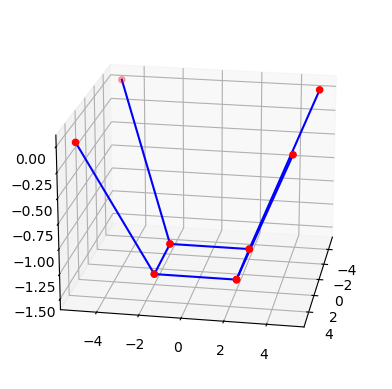

In [523]:
N = 8
X = np.zeros((3,N))
A = np.zeros((N,N))
X[:,0] = [5,5,0]
X[:,1] = [-5,5,0]
X[:,2] = [-5,-5,0]
X[:,3] = [5,-5,0]
#X[:,4:] = np.random.randint(2, size = np.shape(X[:,4:]))


edges = np.array([[1,5], [5,6], [4,5], [2,6], [6,7], [3,7], [4,7], [0,4]])
create_edge(A, edges[:,0], edges[:,1])
fixed_points = [0,1,2,3]

X = BFGS(E,gradient_E,X,A,fixed_points, 1/6, 1e-14)
print(X)

plt.figure()
ax0 = plt.axes(projection = '3d')
plot_cable_net(X, A, ax0)
ax0.view_init(20,10)

number of gradient descent steps = 129, number of step size optimization = 0, norm of gradient = 9.150065638521767e-09, Energy = 1.166666666666667
[[ 5.         -5.         -5.          5.          2.         -2.
  -2.          2.        ]
 [ 5.          5.         -5.         -5.          2.          2.
  -2.         -2.        ]
 [ 0.          0.          0.          0.         -1.49999996 -1.49999996
  -1.49999996 -1.49999996]]
number of gradient descent steps = 46, number of step size optimization = 371, norm of gradient = 6.675125910748806e-09, Energy = 1.1666666666666665
[[ 5.         -5.         -5.          5.          2.         -2.
  -2.          2.        ]
 [ 5.          5.         -5.         -5.          2.          2.
  -2.         -2.        ]
 [ 0.          0.          0.          0.         -1.49999997 -1.49999997
  -1.49999997 -1.49999997]]
number of steps = 27, norm of gradient = 4.420957001434901e-09, Energy = 1.166666666666666
[[ 5.         -5.         -5.        

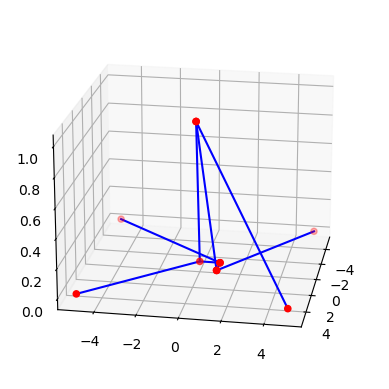

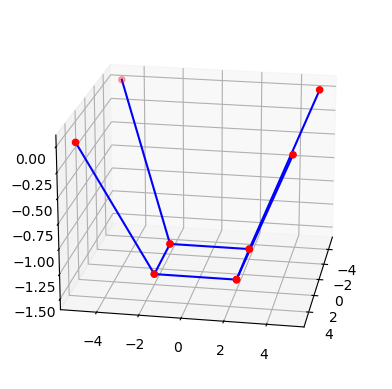

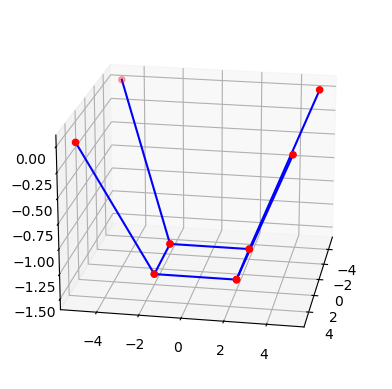

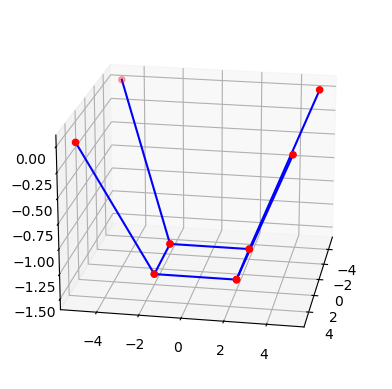

In [524]:
N = 8
X = np.zeros((3,N))
A = np.zeros((N,N))
X[:,0] = [5,5,0]
X[:,1] = [-5,5,0]
X[:,2] = [-5,-5,0]
X[:,3] = [5,-5,0]
X[:,4:] = np.random.randint(2, size = np.shape(X[:,4:]))


edges = np.array([[1,5], [5,6], [4,5], [2,6], [6,7], [3,7], [4,7], [0,4]])
create_edge(A, edges[:,0], edges[:,1])
fixed_points = [0,1,2,3]

plt.figure()
ax0 = plt.axes(projection = '3d')
plot_cable_net(X, A, ax0)
ax0.view_init(20,10)

plt.figure()
ax1 = plt.axes(projection = '3d')
X_const_step = gradient_descent(E, gradient_E, np.copy(X), A, fixed_points, 1/6, 1e-8)
plot_cable_net(X_const_step, A, ax1)
ax1.view_init(20,10)
print(X_const_step)

plt.figure()
ax1 = plt.axes(projection = '3d')
X_armijo = gradient_descent(E, gradient_E, np.copy(X), A, fixed_points, 1/6, 1e-8, alpha_0 = 1, armijo= True)
plot_cable_net(X_armijo, A, ax1)
ax1.view_init(20,10)
print(X_armijo)

plt.figure()
ax2 = plt.axes(projection = '3d')
X_BFGS = BFGS(E, gradient_E, np.copy(X), A, fixed_points, 1/6, 1e-8, strong_w=True)
plot_cable_net(X_BFGS, A, ax2)
ax2.view_init(20,10)
print(X_BFGS)

number of gradient descent steps = 46, number of step size optimization = 880, norm of gradient = 1.5430517974479585e-09, Energy = 1.1666666666666663
[[ 5.         -5.         -5.          5.          2.         -2.
  -2.          2.        ]
 [ 5.          5.         -5.         -5.          2.          2.
  -2.         -2.        ]
 [ 0.          0.          0.          0.         -1.49999999 -1.49999999
  -1.49999999 -1.49999999]]
number of gradient descent steps = 50, number of step size optimization = 1164, norm of gradient = 8.257639128039784e-09, Energy = 1.1666666666666665
[[ 5.         -5.         -5.          5.          2.         -2.
  -2.          2.        ]
 [ 5.          5.         -5.         -5.          2.          2.
  -2.         -2.        ]
 [ 0.          0.          0.          0.         -1.49999997 -1.49999997
  -1.49999997 -1.49999997]]


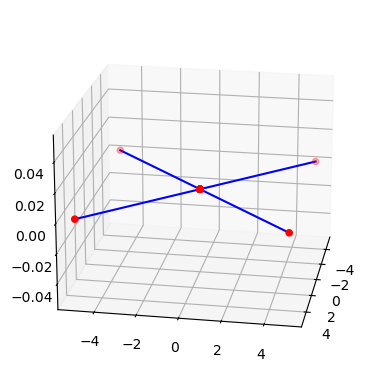

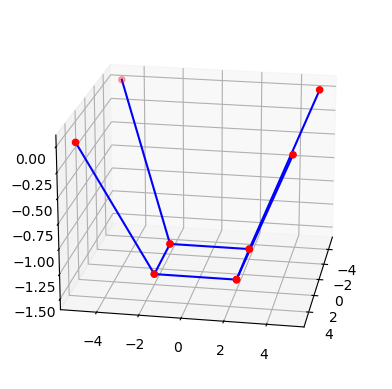

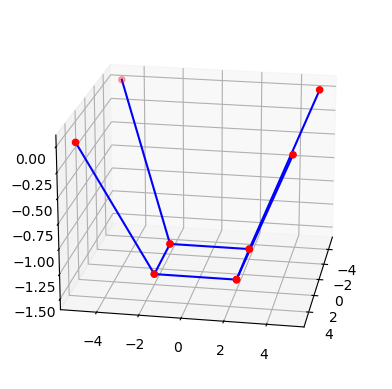

In [525]:
N = 8
X = np.zeros((3,N))
A = np.zeros((N,N))
X[:,0] = [5,5,0]
X[:,1] = [-5,5,0]
X[:,2] = [-5,-5,0]
X[:,3] = [5,-5,0]
#X[:,4:] = np.random.randint(2, size = np.shape(X[:,4:]))


edges = np.array([[1,5], [5,6], [4,5], [2,6], [6,7], [3,7], [4,7], [0,4]])
create_edge(A, edges[:,0], edges[:,1])
fixed_points = [0,1,2,3]

plt.figure()
ax0 = plt.axes(projection = '3d')
plot_cable_net(X, A, ax0)
ax0.view_init(20,10)

plt.figure()
ax1 = plt.axes(projection = '3d')
X_weak_wolfe = gradient_descent(E, gradient_E, np.copy(X), A, fixed_points, 1/6, 1e-8, alpha_0 = 3, weak_w = True)
plot_cable_net(X_weak_wolfe, A, ax1)
ax1.view_init(20,10)
print(X_weak_wolfe)

plt.figure()
ax1 = plt.axes(projection = '3d')
X_strong_wolfe = gradient_descent(E, gradient_E, np.copy(X), A, fixed_points, 1/6, 1e-8, alpha_0 = 3, strong_w = True)
plot_cable_net(X_strong_wolfe, A, ax1)
ax1.view_init(20,10)
print(X_strong_wolfe)

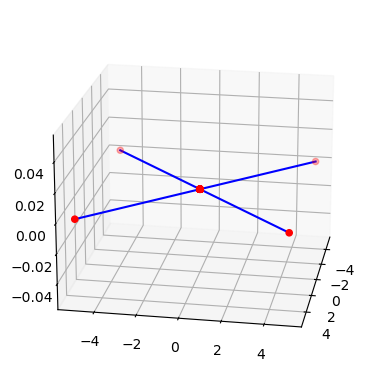

In [526]:
N = 13
X = np.zeros((3,N))
A = np.zeros((N,N))
a = 5
X[:,0] = [a,a,0]
X[:,1] = [-a,a,0]
X[:,2] = [-a,-a,0]
X[:,3] = [a,-a,0]
#X[:,4:] = np.random.randint(3, size = np.shape(X[:,4:]))
#X[:,12] = [0,0,-10]
edges = np.array([[1,5], [2,6], [3,7],[0,4], [4,5], [5,6], [6,7], [4,7], [4,8], [5,9], [6,10], [7,11], [4,8], [8,9],[9,10],[10,11],[11,8], [8,12], [9,12], [10,12], [11,12] ])
create_edge(A, edges[:,0], edges[:,1])
fixed_points = [0,1,2,3]

plt.figure()
ax0 = plt.axes(projection = '3d')
plot_cable_net(X, A, ax0)
ax0.view_init(20,10)


number of gradient descent steps = 281, number of step size optimization = 0, norm of gradient = 9.397278955464959e-09, Energy = -3.7248442848391896


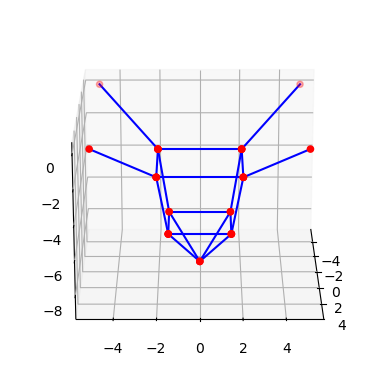

In [527]:
plt.figure()
ax1 = plt.axes(projection = '3d')
X_const_step = gradient_descent(E, gradient_E, np.copy(X), A, fixed_points, 1/6, 1e-8)
plot_cable_net(X_const_step,A, ax1)
ax1.view_init(20,0)

number of gradient descent steps = 129, number of step size optimization = 1339, norm of gradient = 6.6873614053193685e-09, Energy = -3.7248442848391914


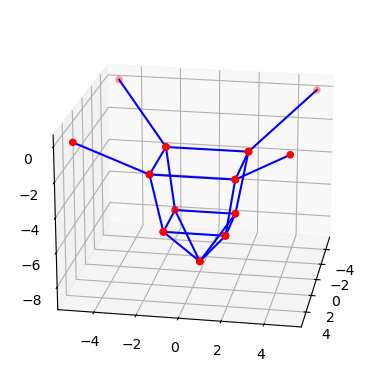

In [528]:
plt.figure()
ax2 = plt.axes(projection = '3d')
X_armijo = gradient_descent(E, gradient_E, np.copy(X), A, fixed_points, 1/6, 1e-8, alpha_0 = 3, armijo= True)
plot_cable_net(X_const_step,A, ax2)
ax2.view_init(20,10)

number of gradient descent steps = 166, number of step size optimization = 2863, norm of gradient = 5.922400196554447e-09, Energy = -3.724844284839192


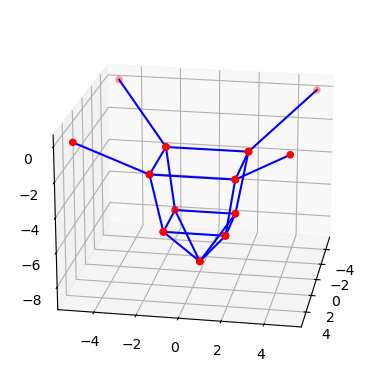

In [529]:
plt.figure()
ax3 = plt.axes(projection = '3d')
X_weak_wolfe = gradient_descent(E, gradient_E, np.copy(X), A, fixed_points, 1/6, 1e-8, weak_w= True)
plot_cable_net(X_weak_wolfe,A, ax3)
ax3.view_init(20,10)

number of gradient descent steps = 161, number of step size optimization = 3009, norm of gradient = 6.827782777958486e-09, Energy = -3.7248442848391927


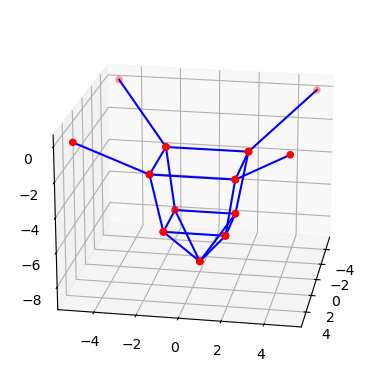

In [530]:
plt.figure()
ax4 = plt.axes(projection = '3d')
X_strong_wolfe = gradient_descent(E, gradient_E, np.copy(X), A, fixed_points, 1/6, 1e-8, strong_w= True)
plot_cable_net(X_strong_wolfe, A, ax4)
ax4.view_init(20,10)

number of steps = 83, norm of gradient = 8.591269426568908e-14, Energy = -3.7248442848391896
[[ 5.00000000e+00 -5.00000000e+00 -5.00000000e+00  5.00000000e+00
   2.04728152e+00 -2.04728152e+00 -2.04728152e+00  2.04728152e+00
   1.50725408e+00 -1.50725408e+00 -1.50725408e+00  1.50725408e+00
   3.22462764e-15]
 [ 5.00000000e+00  5.00000000e+00 -5.00000000e+00 -5.00000000e+00
   2.04728152e+00  2.04728152e+00 -2.04728152e+00 -2.04728152e+00
   1.50725408e+00  1.50725408e+00 -1.50725408e+00 -1.50725408e+00
  -4.02164514e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.79279847e+00 -2.79279847e+00 -2.79279847e+00 -2.79279847e+00
  -6.35099556e+00 -6.35099556e+00 -6.35099556e+00 -6.35099556e+00
  -8.69587808e+00]]


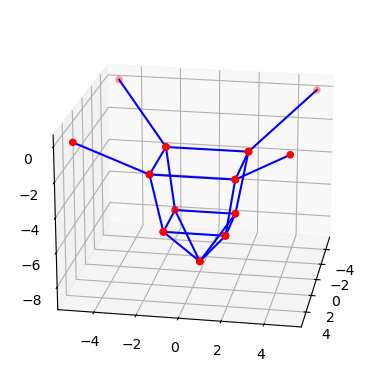

In [531]:
plt.figure()
ax4 = plt.axes(projection = '3d')
X_BFGS = BFGS(E, gradient_E, np.copy(X), A, fixed_points, 1/6, 1e-13, strong_w = True)
plot_cable_net(X_BFGS, A, ax4)
ax4.view_init(20,10)
print(X_BFGS)